In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm 
import os
import pandas as pd
import re
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm 
import os
import pandas as pd

In [ ]:
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else float('inf')

def sort_files(activations_directory):
  activation_folder_list = os.listdir(activations_directory)
  activation_folder_list = sorted(activation_folder_list, key=extract_number, reverse=False)
  return activation_folder_list 


In [ ]:

# Assuming a data set with variable length tokens, token_output_focus determines which token to focus on for each element of the data set
# Assumes filename corresponds to the class of the prompt
def build_activations_array(
    activations_directory, 
    activation_folder_list, 
    token_output_focus = "first", 
    first_n_files=None):
    
  if first_n_files is None:
    first_n_files = len(activation_folder_list)
    
  tokenizer = LlamaTokenizer.from_pretrained('../../models/llama-7b-hf', local_files_only=True)
  # Array of arrays 
  all_prompt_activations = [] 
  all_prompt_filenames = []
  all_prompt_tokens = []

  # Load the CSV file into a pandas DataFrame
  df = pd.read_csv(activations_directory+'Task.csv')

  # Create a dictionary that maps question IDs to classes
  id_to_class = df.set_index('Question_ID')['Class'].to_dict()
  id_to_q_type = df.set_index('Question_ID')['Question_Type'].to_dict()
#   print(id_to_class)
#   print(id_to_q_type)

  activation_folder_list = [f for f in activation_folder_list if os.path.splitext(f)[1] == '.pt']

  for activation_file in tqdm((activation_folder_list[:first_n_files]), position=0, leave=True):
      # Extract the question ID from the filename
      question_id = int(re.search(r"^Question_(\d+)_", activation_file).group(1))
      
      # Check if the question type is 'character_qa_close' before proceeding
      if id_to_q_type[question_id] == 'character_qa_close':
#       if 1:
#           Use the dictionary to get the corresponding class

          activation_path = os.path.join(activations_directory,str(activation_file))
          data = torch.load(activation_path, map_location=torch.device('cpu'))


          hidden_states = data['hidden_states']
          output_response = data['output'].split("Response:")[1]
          tokenized_output_response = tokenizer.encode(output_response)

          

          if token_output_focus == "first":
            token_id = 3 # Disregard first hidden state (which inclued all input? tokens), and disregard first two tokens (['', '<0x0A>',)
          if token_output_focus == "last":
              token_id = len(hidden_states) - 1
              token_text = tokenizer.decode(tokenized_output_response[token_id])
#               Check if token_text is not one of the specified strings
              if token_text not in ["Yes", "yes", "No", "no"]:
                  token_id = len(hidden_states) - 2 # n-1 to avoid full stop
                  token_text = tokenizer.decode(tokenized_output_response[token_id])
                  if token_text not in ["Yes", "yes", "No", "no"]:
                    print("output neither yes or no")
                    continue

#           filename = id_to_class[question_id] +'_'+ id_to_q_type[question_id]+'_'+token_text
          filename = id_to_class[question_id]
          all_prompt_filenames.append(filename)
          
          token_hidden_states = hidden_states[token_id]

          # Initialize an empty dictionary to store activations
          activations = []

          # iterate through all layers for each token's hidden states
          for layer_id, layers in enumerate(token_hidden_states):
            # print("Layer: "+str(layer_id))
            for beam_id, beams in enumerate(layers):
              # print("Beam: "+str(beam_id))
              for token_activation_id, token_activations in enumerate(beams):
                # print(token_activations.shape)
                token_activations_np = token_activations.numpy()  # Detach and convert to NumPy array
                activations.extend(token_activations_np)
          token_text = tokenizer.decode(tokenized_output_response[token_id])
          all_prompt_activations.append(activations)
          all_prompt_tokens.append(token_text)

  return all_prompt_activations, all_prompt_filenames, all_prompt_tokens

In [ ]:
activations_directory = "/home/gridsan/wzulfikar/activations/dataset_trex/"
#Sort files
activation_folder_list = sort_files(activations_directory)
#Set params
token_output_focus = "last"
first_n_files = 800

all_prompt_activations, all_prompt_filenames, all_prompt_tokens = build_activations_array(activations_directory, activation_folder_list, token_output_focus = token_output_focus, first_n_files = first_n_files)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
100%|██████████| 800/800 [03:58<00:00,  3.35it/s]


In [ ]:
start = time.time()

# Create a structured numpy array
dtype = np.dtype([('question_id', np.int64), ('question_class', object), ('neuron_id', np.int64), ('neuron_activation_value', np.float64)])
activations_data = np.empty((len(all_prompt_activations), len(all_prompt_activations[0])), dtype=dtype)

# Fill the structured array
for j, (activations, filename) in enumerate(zip(all_prompt_activations, all_prompt_filenames)):
    activations_data['question_id'][j] = j
    activations_data['question_class'][j] = filename
    activations_data['neuron_id'][j] = np.arange(len(activations))
    activations_data['neuron_activation_value'][j] = activations

# Convert the structured array to a DataFrame
activations_df = pd.DataFrame(activations_data.ravel())

activations_df.to_csv('/home/gridsan/wzulfikar/activations/dataset_trex/all_activations.csv')
print("Time taken", time.time()-start)


Time taken 180.62013816833496


In [ ]:
start = time.time()

# Group by question_class and get unique question ids for each class name
grouped = activations_df.groupby('question_class')['question_id'].nunique()

# Print the class names and the number of unique question ids
for class_name, n_unique in grouped.items():
    print(f'Class name: {class_name}, Number of unique question ids: {n_unique}')

print("Time taken", time.time()-start)

Class name: Ada Lovelace, Number of unique question ids: 26
Class name: Albert Einstein, Number of unique question ids: 28
Class name: Barney the Dinosaur, Number of unique question ids: 19
Class name: Cleopatra, Number of unique question ids: 27
Class name: Harry Potter, Number of unique question ids: 28
Class name: Hermione Granger, Number of unique question ids: 27
Class name: Isaac Newton, Number of unique question ids: 27
Class name: Lady Gaga, Number of unique question ids: 29
Class name: Marie Curie, Number of unique question ids: 27
Class name: Princess Leia, Number of unique question ids: 28
Class name: Sherlock Holmes, Number of unique question ids: 28
Class name: Socrates, Number of unique question ids: 29
Class name: Vincent Van Gogh, Number of unique question ids: 29
Class name: William Shakespeare, Number of unique question ids: 27
Time taken 7.26537299156189


In [ ]:
# Pivot the dataframe to get the desired format
clustering_df = activations_df.pivot(index='neuron_id', columns='question_id', values='neuron_activation_value')

# The resulting dataframe shape would be (n_neurons, n_questions)
print(clustering_df.shape)

(209920, 379)


## K Means

1. Take the transpose of data (neuron_activations, n_trials)
2. Cluster the neurons such that each cluster contains neurons that responded similarly across all trials
3. Find the mean activation for each cluster based on the activations of the neurons for each trial [output shape - (n_clusters, n_trials)]

In [ ]:
import cudf
import cuml

start = time.time()

n_neurons = clustering_df.shape[0]
n_questions = clustering_df.shape[1]
print(n_neurons, n_questions)

# Convert your data to cuDF DataFrame, because cuML works with cuDF DataFrame
# df = cudf.DataFrame(clustering_df, columns=[f'question_{i+1}' for i in range(n_questions)])

# Initialize the KMeans model
kmeans = cuml.KMeans(n_clusters=14)

print("Fitting")
# Fit the model
kmeans.fit(clustering_df)

# Get cluster predictions
clustering_df['cluster_id'] = kmeans.predict(clustering_df)

print("Time taken ", time.time() - start)

209920 379
Fitting
Time taken  55.43403720855713


K-means clustering metrics
 

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist
from gap_statistic import OptimalK

def calculate_WCSS(points, centroid):
    return cudf.square(points - centroid).sum(axis=1)

def elbow_method(data, k_max):
    wcss_values = []
    for i in range(1, k_max+1):
        kmeans = cuml.KMeans(n_clusters=i)
        kmeans.fit(data)
        wcss_cluster = sum([calculate_WCSS(data[kmeans.labels_==j], centroid).sum() for j, centroid in enumerate(kmeans.cluster_centers_)])
        wcss_values.append(wcss_cluster)
    plt.plot(range(1, k_max+1), wcss_values)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.grid()
    plt.show()

def silhouette_method(data, k_max):
    silhouette_scores = []
    for i in range(2, k_max+1):
        kmeans = cuml.KMeans(n_clusters=i)
        kmeans.fit(data)
        score = cuml.metrics.silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
    plt.plot(range(2, k_max+1), silhouette_scores)
    plt.title('Silhouette Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

def bic_method(data, k_max):
    bic_values = []
    data_cpu = data.to_pandas() # Convert back to Pandas dataframe for compatibility with sklearn
    for i in range(1, k_max+1):
        gmm = GaussianMixture(n_components=i)
        gmm.fit(data_cpu)
        bic_values.append(gmm.bic(data_cpu))
    plt.plot(range(1, k_max+1), bic_values)
    plt.title('BIC Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('BIC')
    plt.grid()
    plt.show()

def gap_statistic_method(data, k_max):
    gap_values = []
    data_cpu = data.to_pandas().values # Convert to numpy array
    optimalK = OptimalK(parallel_backend='rust')
    n_clusters = optimalK(data_cpu, cluster_array=np.arange(1, k_max))
    optimalK.gap_df.plot.line(x='n_clusters', y='gap_value', title='Gap Statistic Method')
    plt.grid()
    plt.show()

# your dataframe here
clustering_df = cudf.DataFrame()

start = time.time()

elbow_method(clustering_df, 10)
silhouette_method(clustering_df, 10)
bic_method(clustering_df, 10)
gap_statistic_method(clustering_df, 10)

print("Time taken ", time.time() - start)


## DBSCAN Clustering

In [ ]:
start = time.time()

n_neurons = clustering_df.shape[0]
n_questions = clustering_df.shape[1]
print(n_neurons, n_questions)

# Initialize the DBSCAN model
dbscan = cuml.DBSCAN(eps=3, min_samples=2)

print("Fitting")
# Fit the model
dbscan.fit(clustering_df)

# Get cluster predictions
clustering_df['cluster_id'] = dbscan.labels_

print("Time taken ", time.time() - start)


In [ ]:
# Assume 'clustering_df' has a 'cluster_id' column that denotes the cluster for each neuron.
# First, reset the index so that 'neuron_id' is a column, not an index.
clustering_df_reset = clustering_df.reset_index()

# Now, merge the 'activations_df' with 'clustering_df' on 'neuron_id'
# This will add the 'cluster_id' from 'clustering_df' to 'activations_df'
clustered_activations_df = pd.merge(activations_df, clustering_df_reset[['neuron_id', 'cluster_id']], on='neuron_id', how='left')


In [ ]:
# Group by cluster_id and get unique neuron ids for each cluster
grouped = clustered_activations_df.groupby('cluster_id')['neuron_id'].nunique()

# Print the cluster ids and the count of unique neurons
for cluster_id, n_unique in grouped.items():
    print(f'Cluster ID: {cluster_id}, Count of unique neurons: {n_unique}')

    
clustered_activations_df.to_csv('/home/gridsan/wzulfikar/activations/dataset_trex/clustered_activations.csv')


In [ ]:
clustered_activations_df = pd.read_csv('/home/gridsan/wzulfikar/activations/dataset_trex/clustered_activations.csv')

In [ ]:
embedding_size = 5120
n_layers = 41
neuron_addr_per_cluster = {}

for cluster_id, group in clustered_activations_df.groupby('cluster_id'):
    # Extract neuron ids
    neuron_ids = group['neuron_id'].unique()
    # Calculate layer ids and embedding ids
    layer_ids = neuron_ids // embedding_size
    embedding_ids = neuron_ids % embedding_size
    # Store in dictionary
    neuron_addr_per_cluster[cluster_id] = pd.DataFrame({
        'neuron_id': neuron_ids,
        'layer_id': layer_ids,
        'embedding_id': embedding_ids
    })
    
    print(cluster_id, len(neuron_ids))

0 33
1 33
2 45432
3 33
4 33
5 33
6 67
7 33
8 42875
9 14
10 84
11 280
12 120937
13 33


## Visualize the clusters

/state/partition1/slurm_tmp/22924967.0.0/ipykernel_42778/1828770438.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)  # Remove padding between subplots


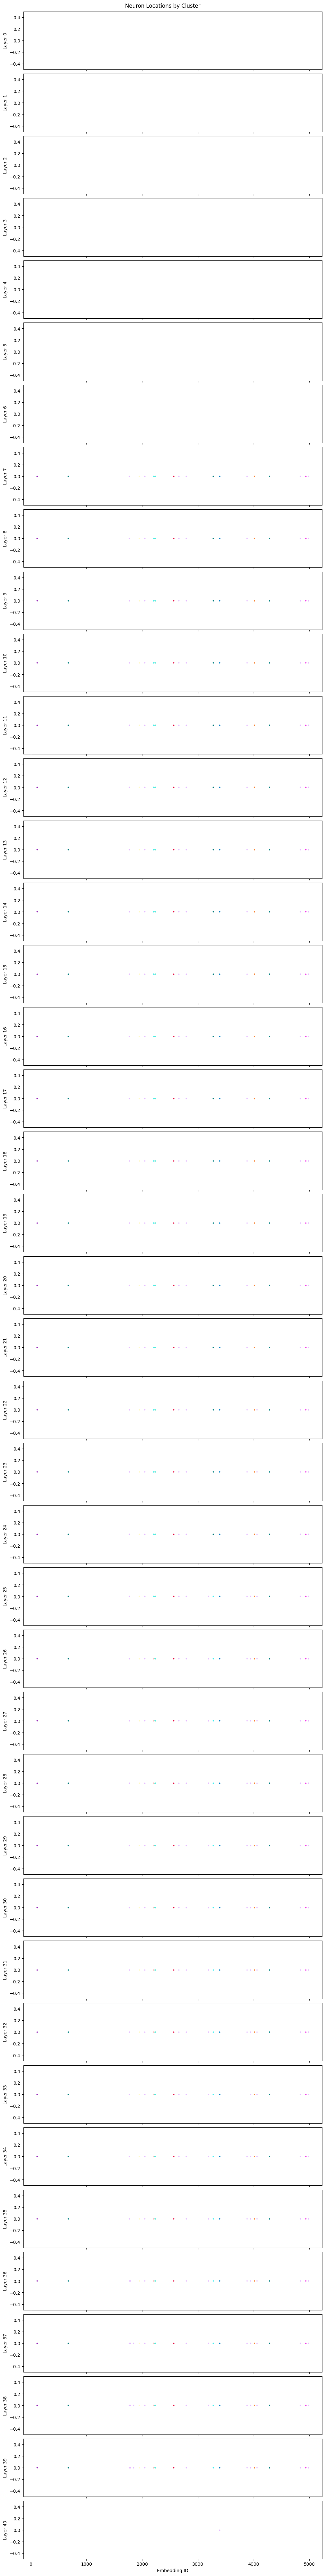

In [ ]:
# Define a list of distinct colors
colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#d2f53c', '#fabebe', '#008080', '#e6beff', '#aa6e28', '#fffac8', '#800000', '#aaffc3']

# Create a subplot for each layer
fig, axs = plt.subplots(41, 1, figsize=(10, 80), sharex=True, constrained_layout=True)
fig.subplots_adjust(hspace=0)  # Remove padding between subplots
fig.suptitle('Neuron Locations by Cluster')

# Loop over each cluster and plot the neurons
for cluster_id, df in neuron_addr_per_cluster.items():
    if cluster_id==12 or cluster_id==8 or cluster_id==2:
        continue
#     print(cluster_id, df.shape)
    color = colors[cluster_id]  # Select a color for this cluster
    # Loop over each layer in this cluster
    for layer_id, group in df.groupby('layer_id'):
        axs[layer_id].scatter(group['embedding_id'], [0]*len(group), color=color, s=4)

# Set labels and y limits
for i, ax in enumerate(axs):
    ax.set(ylabel='Layer {}'.format(i), ylim=(-0.5, 0.5))
    ax.label_outer()  # Hide x labels and tick labels for all but the bottom subplot.

axs[-1].set(xlabel='Embedding ID')

plt.savefig('/home/gridsan/wzulfikar/activations/clustered_neurons.png')

plt.show()


## Analysis of Clusters

1. Logistic regression of [y = 1 for selected task/character, 0 for all other ones] vs [x = 1 cluster at a time] , so we have n_models = n_clusters
2. For each model, get the r value and p value that tells if that model/cluster significantly encodes whether it is that task/character

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def regression_loo(select_class):
    # Pivot df_with_class to get mean activations for each question and each cluster
    pivot_df = clustered_activations_df.pivot_table(index=['question_id', 'question_class'], columns='cluster_id', values='neuron_activation_value', aggfunc='mean').reset_index()

    # Separate pivot_df based on question_class
    select_df = pivot_df[pivot_df['question_class'] == select_class].drop(columns=['question_id', 'question_class'])
    not_select_df = pivot_df[pivot_df['question_class'] != select_class].drop(columns=['question_id', 'question_class'])

    # Get X and Y
    X = pd.concat([select_df, not_select_df])
    Y = np.concatenate([np.ones(select_df.shape[0]), np.zeros(not_select_df.shape[0])])

    # Shuffle and split dataset to train_test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

    r2_values = {}

    # Fit a separate regression for each cluster
    for i in range(len(X.columns)):
        print(f"Fitting regression for cluster {X.columns[i]}")

        reg = LinearRegression().fit(X_train.iloc[:, i].values.reshape(-1, 1), Y_train)
        
        # Calculate r2 score of the regression and print them
        Y_pred = reg.predict(X_test.iloc[:, i].values.reshape(-1, 1))
        r2 = r2_score(Y_test, Y_pred)
        print(f"R2 Score: {r2}")

        r2_values[X.columns[i]] = r2

#         # Plot the regression line with the datapoints
#         plt.scatter(X_test.iloc[:, i], Y_test, color='blue')
#         plt.plot(X_test.iloc[:, i], Y_pred, color='red', linewidth=2)
#         plt.xlabel('Mean Activation')
#         plt.ylabel('Class Label')
#         plt.title(f"Regression Line for Cluster {X.columns[i]}")
#         plt.show()

    # Print the cluster ID and R2 values in descending order according to R2 values
    print("R2 values by cluster:")
    for cluster_id, r2 in sorted(r2_values.items(), key=lambda item: item[1], reverse=True):
        print(f"Cluster {cluster_id}: {r2}")


Selected Class:  Albert Einstein
Fitting regression for cluster 0
R2 Score: -0.006408148879726294


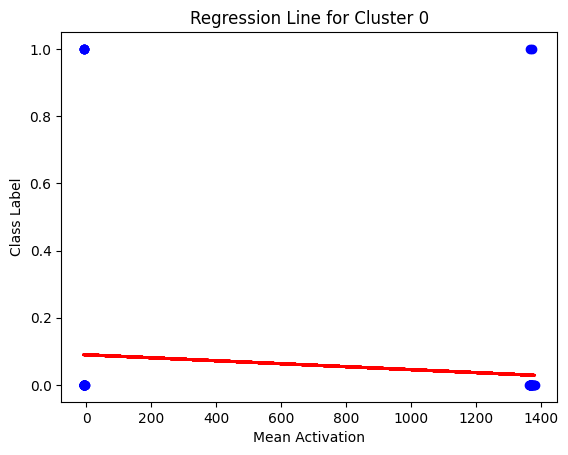

Fitting regression for cluster 1
R2 Score: -0.006385621440236466


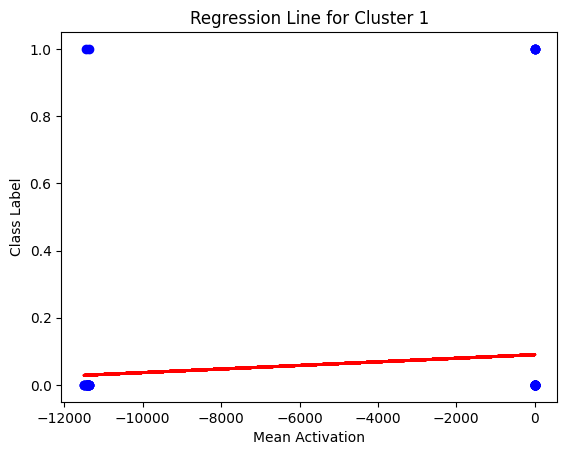

Fitting regression for cluster 2
R2 Score: -0.006265891084218822


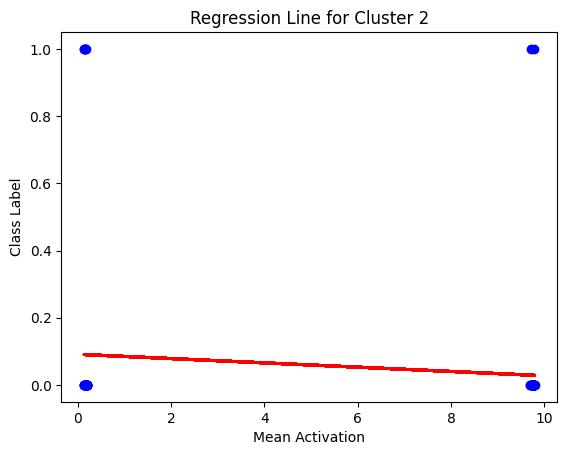

Fitting regression for cluster 3
R2 Score: -0.00639391574278525


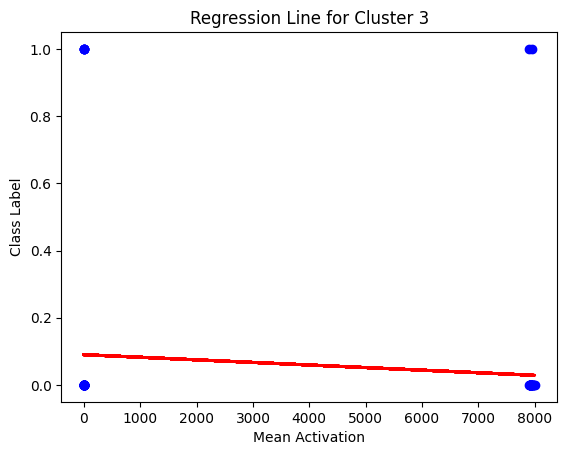

Fitting regression for cluster 4
R2 Score: -0.006360078087289889


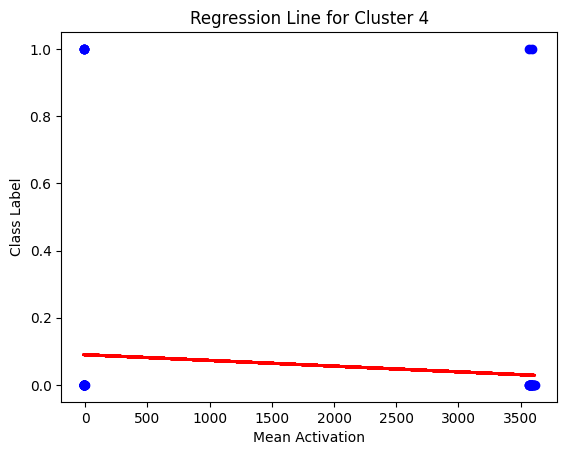

Fitting regression for cluster 5
R2 Score: -0.0062048072657727715


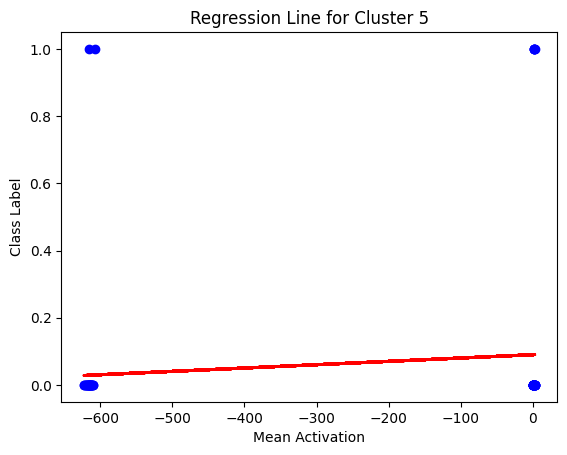

Fitting regression for cluster 6
R2 Score: -0.006217856087546325


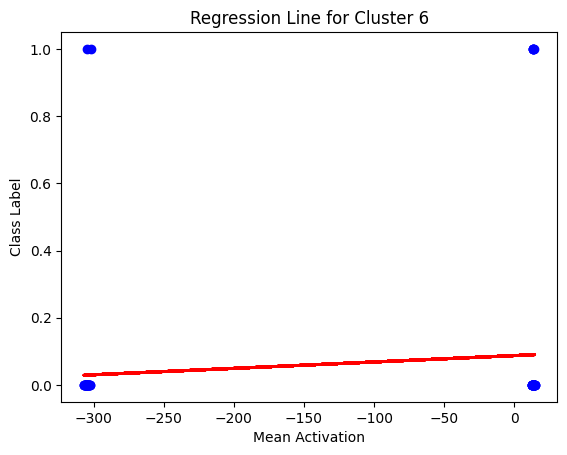

Fitting regression for cluster 7
R2 Score: -0.00630588647810848


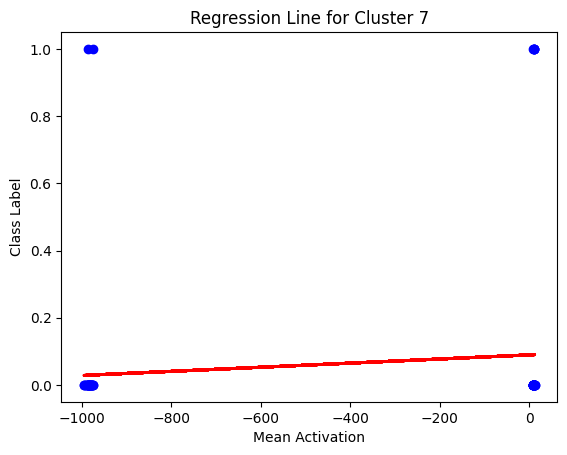

Fitting regression for cluster 8
R2 Score: -0.006393389919995052


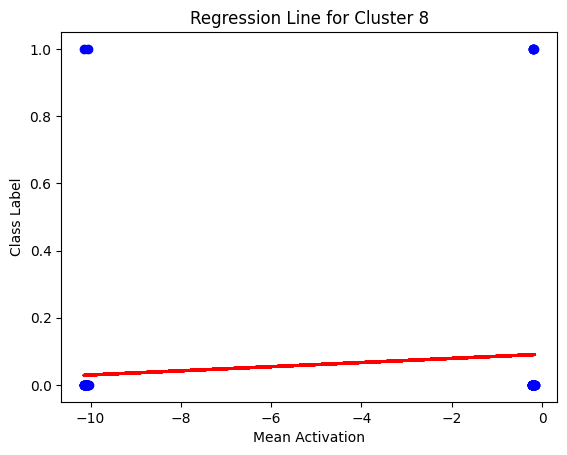

Fitting regression for cluster 9
R2 Score: -0.0059561796877674045


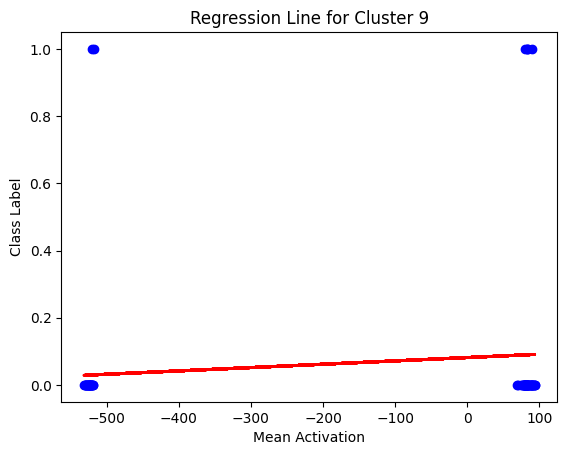

Fitting regression for cluster 10
R2 Score: -0.006530204974724674


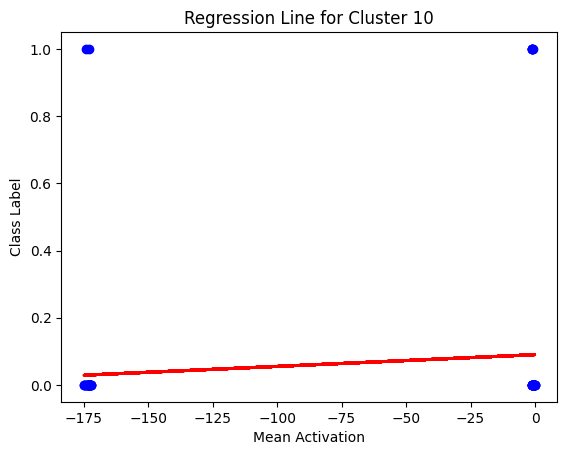

Fitting regression for cluster 11
R2 Score: -0.00626343861212586


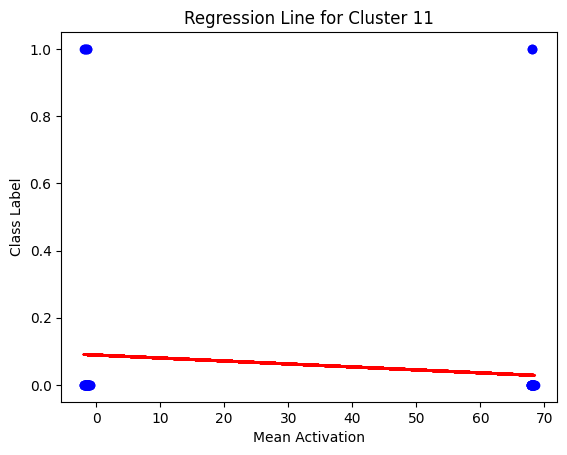

Fitting regression for cluster 12
R2 Score: -0.007628122958933448


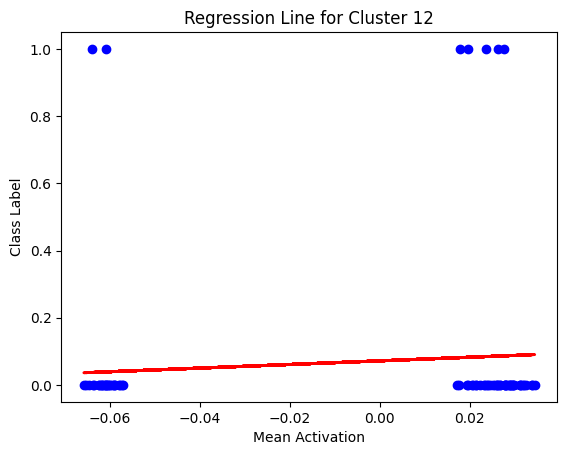

Fitting regression for cluster 13
R2 Score: -0.006470108583162215


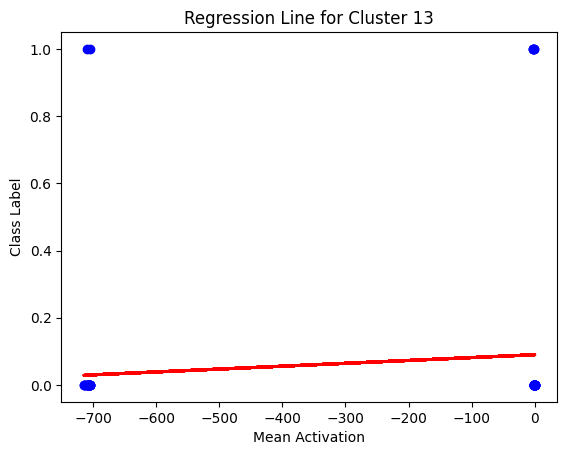

R2 values by cluster:
Cluster 9: -0.0059561796877674045
Cluster 5: -0.0062048072657727715
Cluster 6: -0.006217856087546325
Cluster 11: -0.00626343861212586
Cluster 2: -0.006265891084218822
Cluster 7: -0.00630588647810848
Cluster 4: -0.006360078087289889
Cluster 1: -0.006385621440236466
Cluster 8: -0.006393389919995052
Cluster 3: -0.00639391574278525
Cluster 0: -0.006408148879726294
Cluster 13: -0.006470108583162215
Cluster 10: -0.006530204974724674
Cluster 12: -0.007628122958933448
--------------------
Selected Class:  Vincent Van Gogh
Fitting regression for cluster 0
R2 Score: -0.004729530006275295


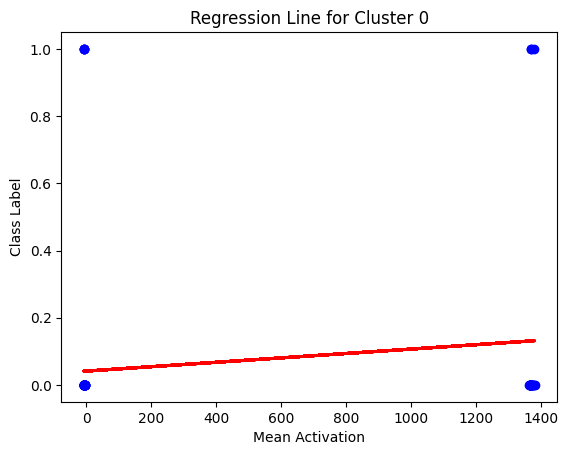

Fitting regression for cluster 1
R2 Score: -0.004679342359964034


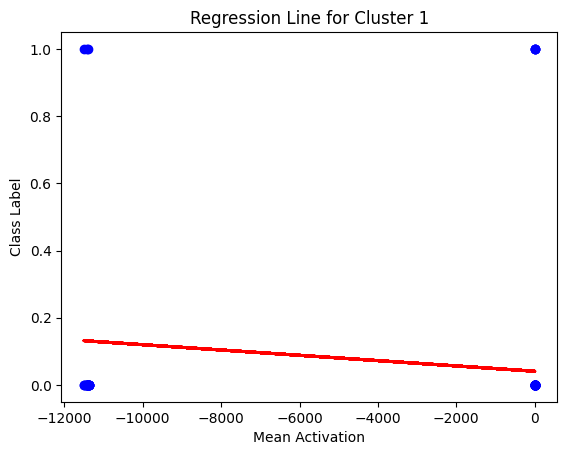

Fitting regression for cluster 2
R2 Score: -0.004846250882564407


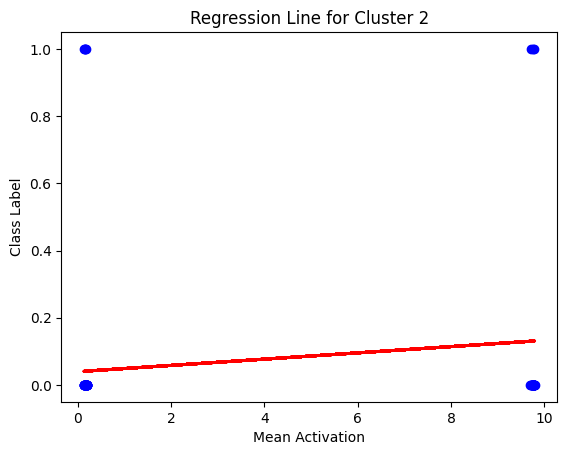

Fitting regression for cluster 3
R2 Score: -0.0047046473734453365


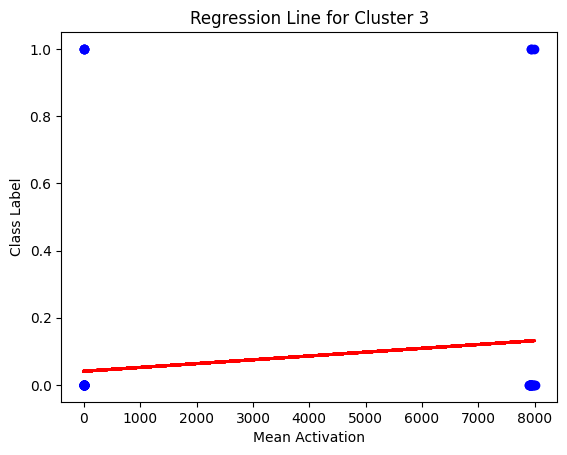

Fitting regression for cluster 4
R2 Score: -0.004716435046144385


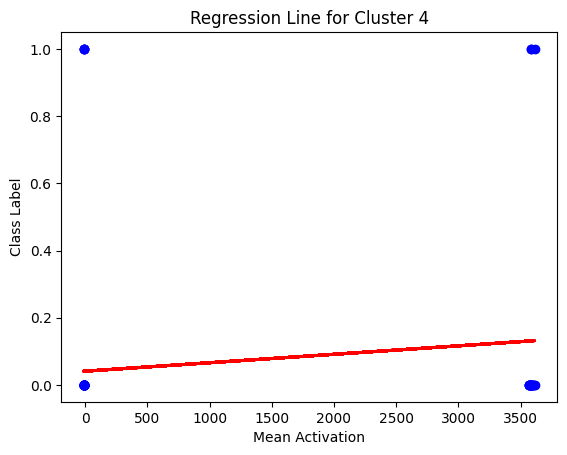

Fitting regression for cluster 5
R2 Score: -0.0046509259931217795


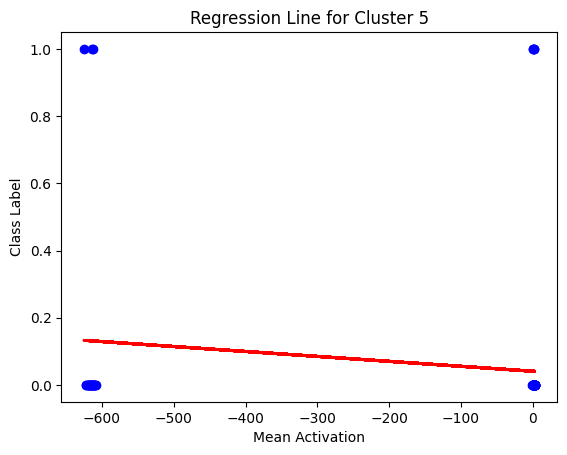

Fitting regression for cluster 6
R2 Score: -0.00475929176258183


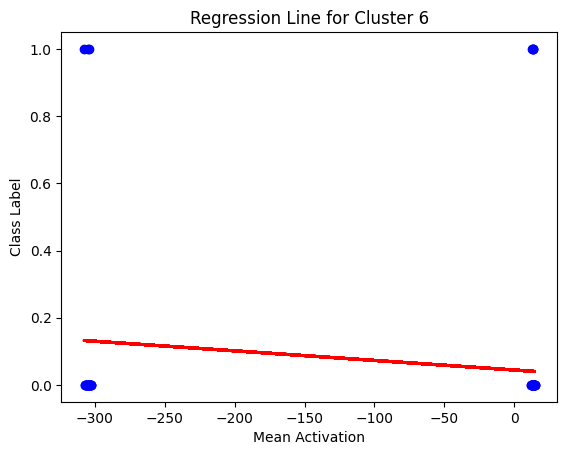

Fitting regression for cluster 7
R2 Score: -0.004692862182960278


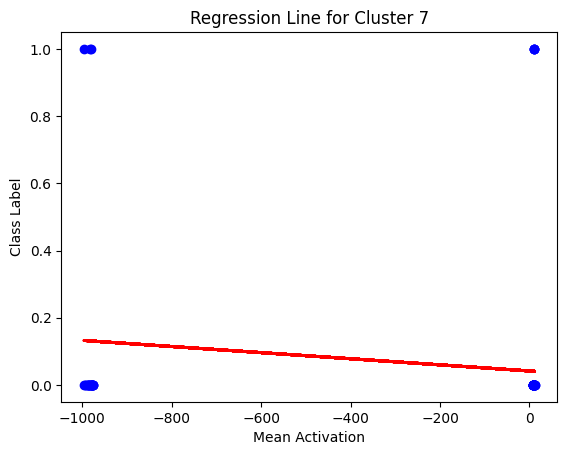

Fitting regression for cluster 8
R2 Score: -0.004767165814689278


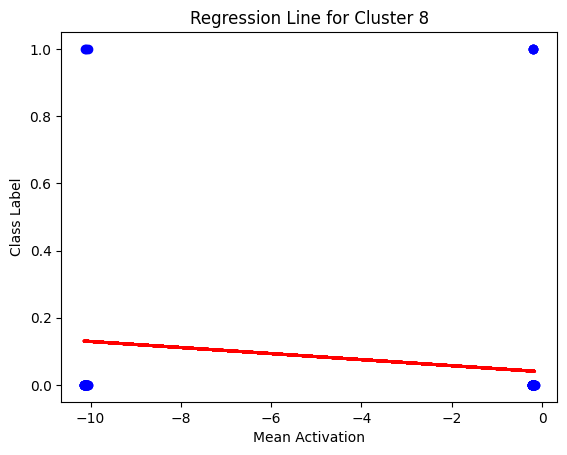

Fitting regression for cluster 9
R2 Score: -0.004622645424816829


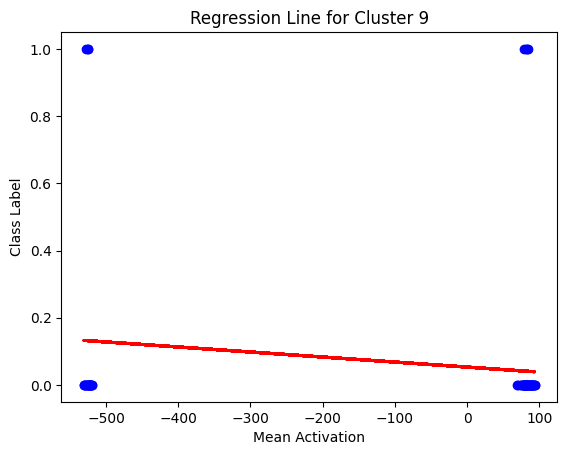

Fitting regression for cluster 10
R2 Score: -0.004566965229237718


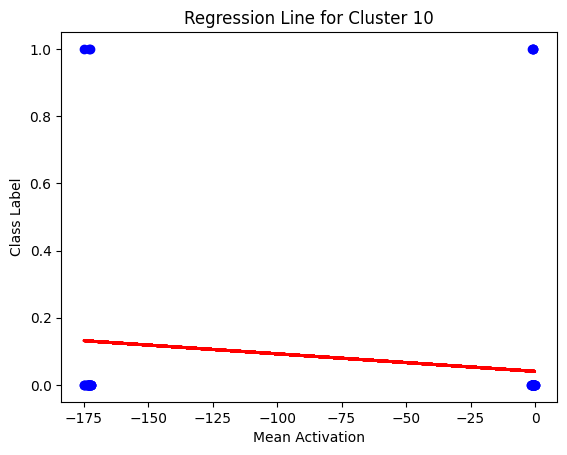

Fitting regression for cluster 11
R2 Score: -0.004752810517561823


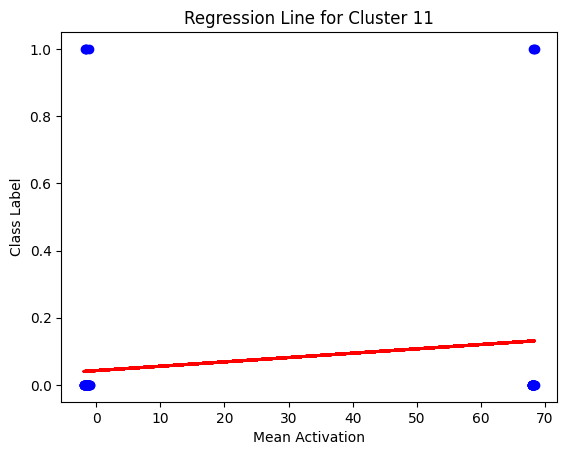

Fitting regression for cluster 12
R2 Score: -0.009307613993266184


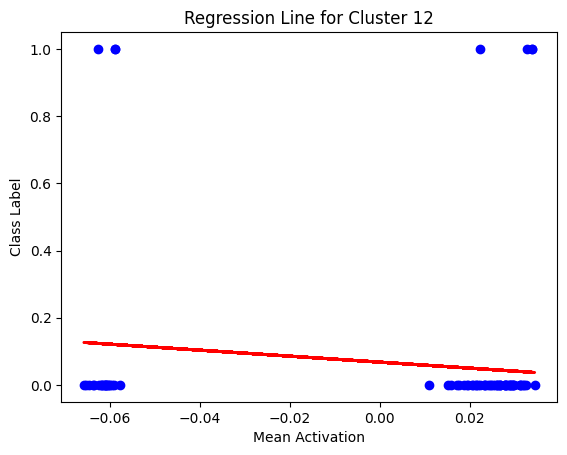

Fitting regression for cluster 13
R2 Score: -0.004668785141173526


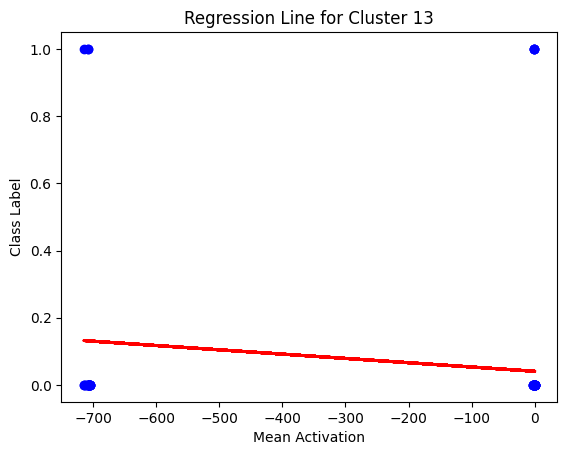

R2 values by cluster:
Cluster 10: -0.004566965229237718
Cluster 9: -0.004622645424816829
Cluster 5: -0.0046509259931217795
Cluster 13: -0.004668785141173526
Cluster 1: -0.004679342359964034
Cluster 7: -0.004692862182960278
Cluster 3: -0.0047046473734453365
Cluster 4: -0.004716435046144385
Cluster 0: -0.004729530006275295
Cluster 11: -0.004752810517561823
Cluster 6: -0.00475929176258183
Cluster 8: -0.004767165814689278
Cluster 2: -0.004846250882564407
Cluster 12: -0.009307613993266184
--------------------
Selected Class:  Marie Curie
Fitting regression for cluster 0
R2 Score: 0.07038684603283751


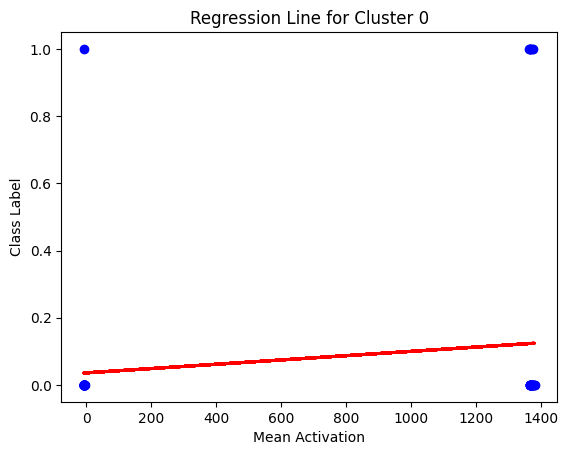

Fitting regression for cluster 1
R2 Score: 0.07044690024584044


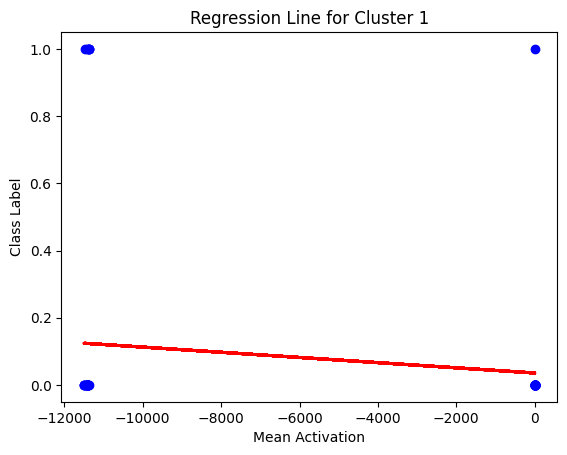

Fitting regression for cluster 2
R2 Score: 0.07089791738846074


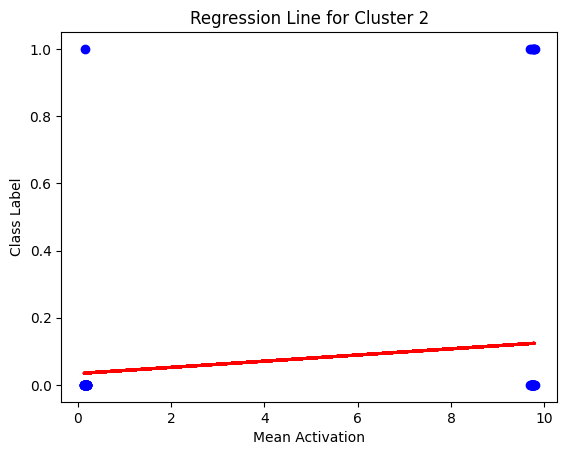

Fitting regression for cluster 3
R2 Score: 0.07041018849872382


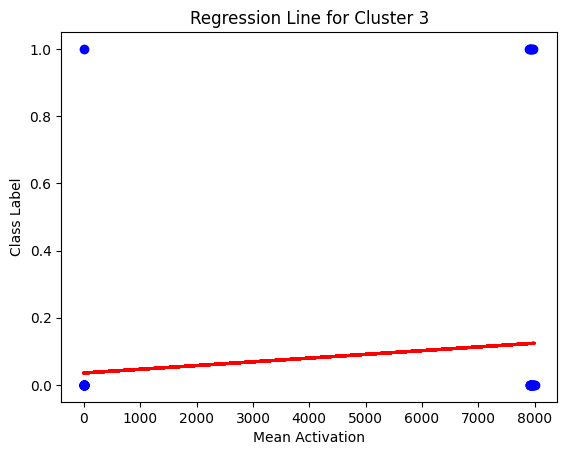

Fitting regression for cluster 4
R2 Score: 0.0703609355851953


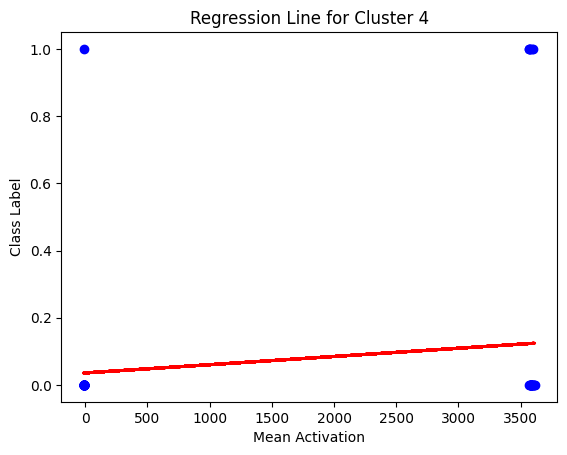

Fitting regression for cluster 5
R2 Score: 0.07016098820080463


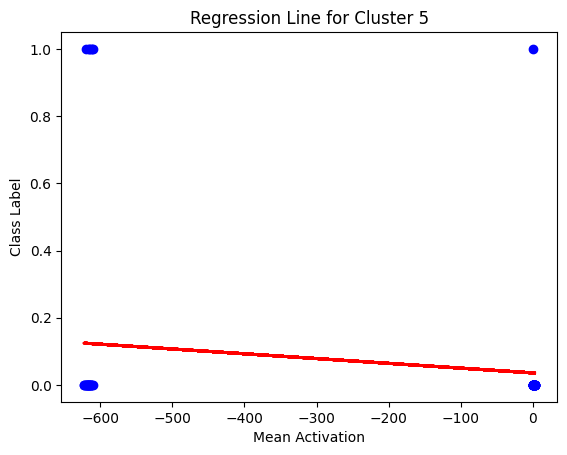

Fitting regression for cluster 6
R2 Score: 0.0700336411313488


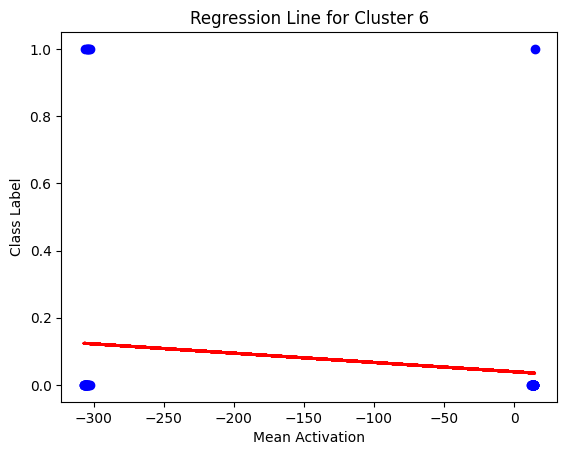

Fitting regression for cluster 7
R2 Score: 0.06996651542401977


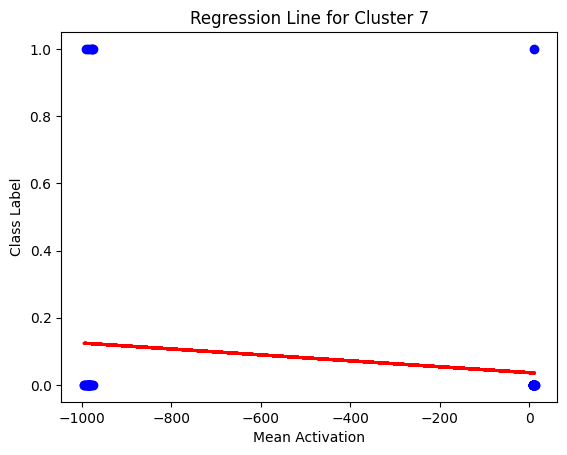

Fitting regression for cluster 8
R2 Score: 0.07112605926178872


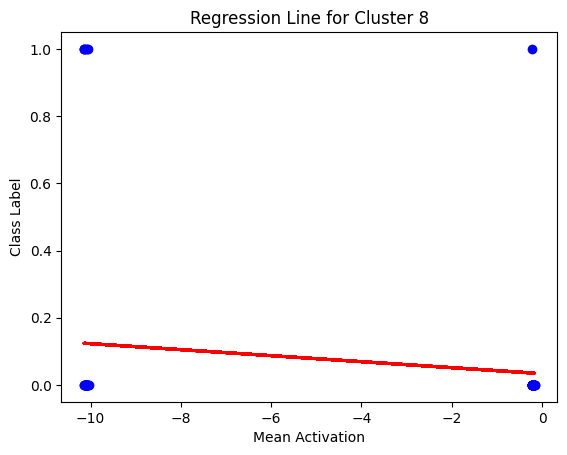

Fitting regression for cluster 9
R2 Score: 0.06817869610091332


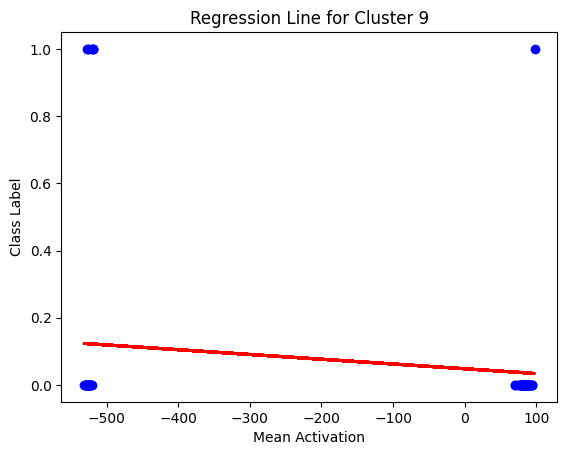

Fitting regression for cluster 10
R2 Score: 0.0705504807752162


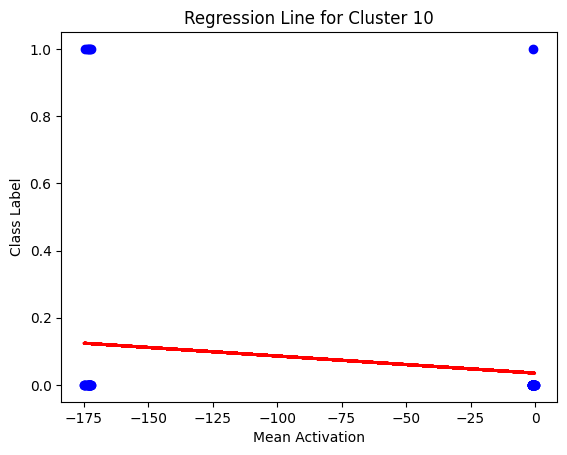

Fitting regression for cluster 11
R2 Score: 0.07036464379136187


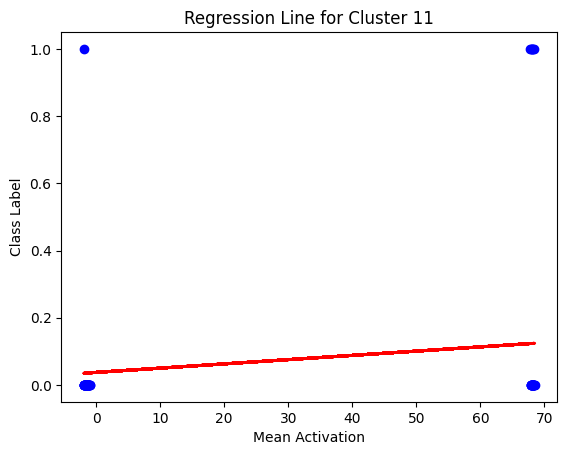

Fitting regression for cluster 12
R2 Score: 0.06456052773188425


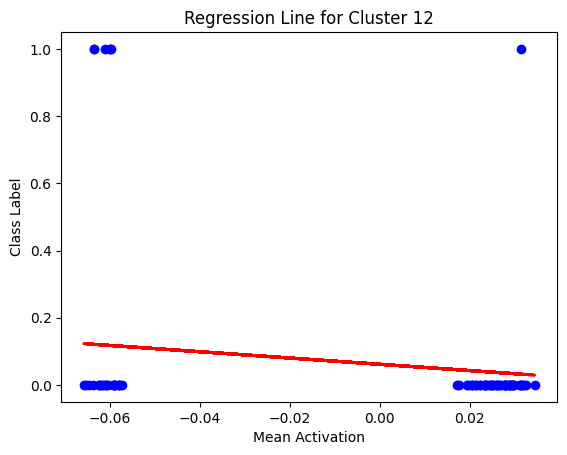

Fitting regression for cluster 13
R2 Score: 0.07030014477969437


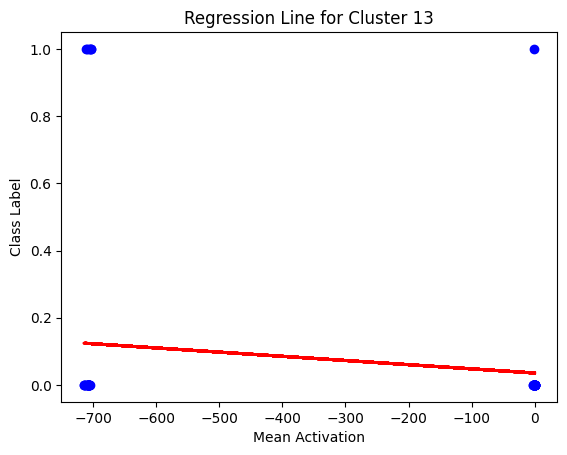

R2 values by cluster:
Cluster 8: 0.07112605926178872
Cluster 2: 0.07089791738846074
Cluster 10: 0.0705504807752162
Cluster 1: 0.07044690024584044
Cluster 3: 0.07041018849872382
Cluster 0: 0.07038684603283751
Cluster 11: 0.07036464379136187
Cluster 4: 0.0703609355851953
Cluster 13: 0.07030014477969437
Cluster 5: 0.07016098820080463
Cluster 6: 0.0700336411313488
Cluster 7: 0.06996651542401977
Cluster 9: 0.06817869610091332
Cluster 12: 0.06456052773188425
--------------------
Selected Class:  Lady Gaga
Fitting regression for cluster 0
R2 Score: 0.0065234656142464376


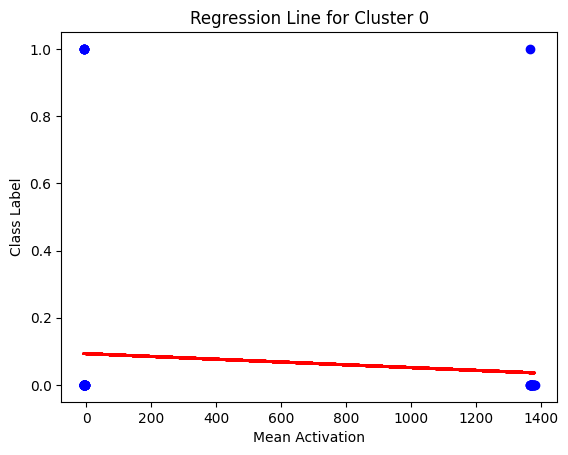

Fitting regression for cluster 1
R2 Score: 0.006500852481743147


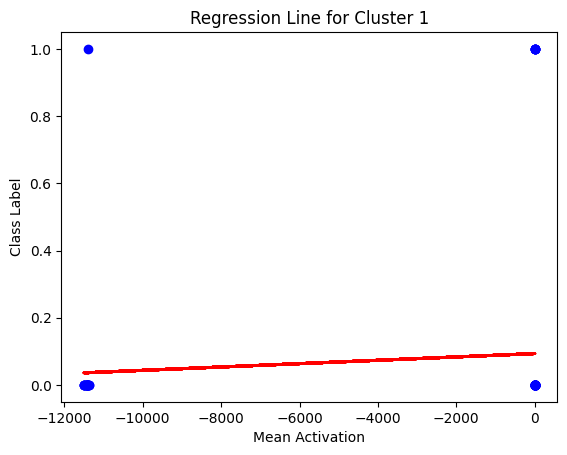

Fitting regression for cluster 2
R2 Score: 0.006215132205194318


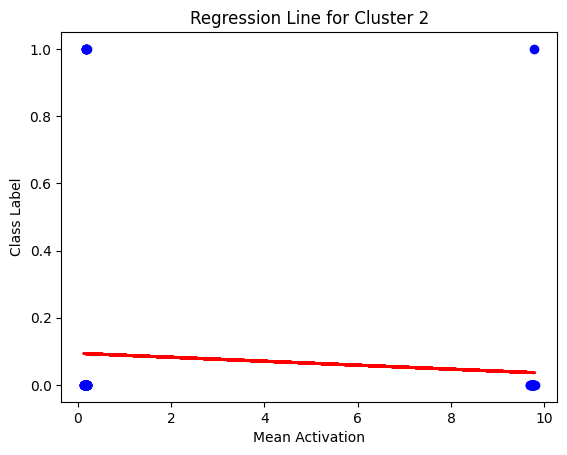

Fitting regression for cluster 3
R2 Score: 0.006506912840079315


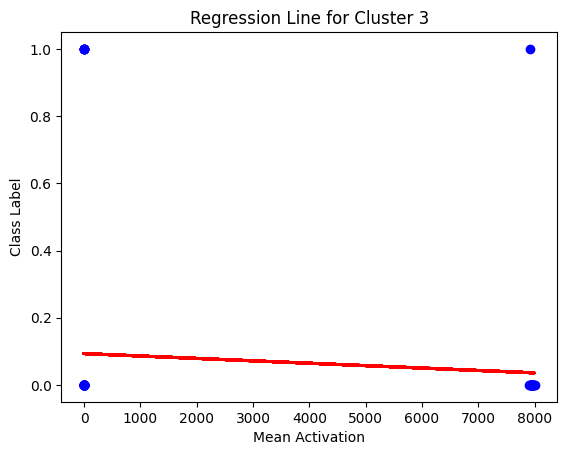

Fitting regression for cluster 4
R2 Score: 0.006487448182953215


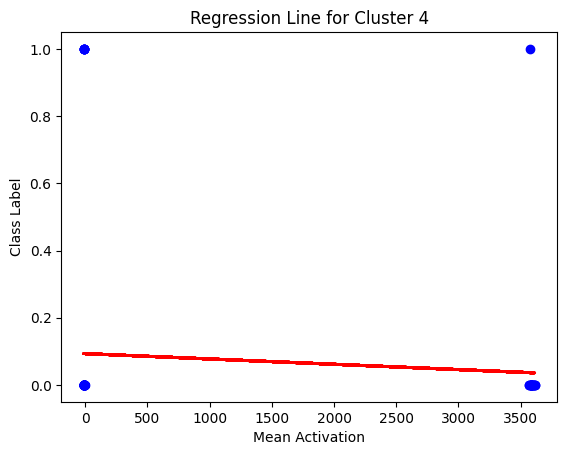

Fitting regression for cluster 5
R2 Score: 0.006389071629759657


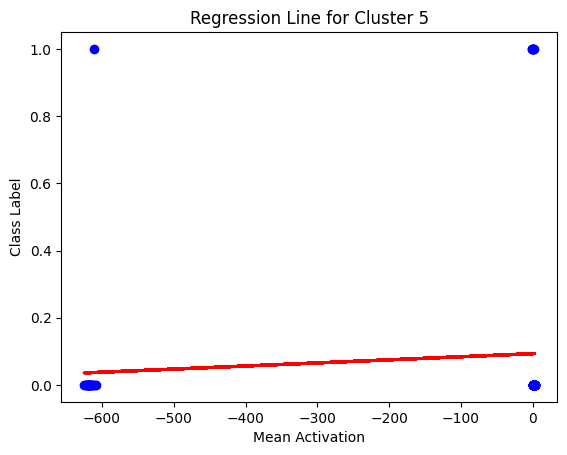

Fitting regression for cluster 6
R2 Score: 0.00669401828112004


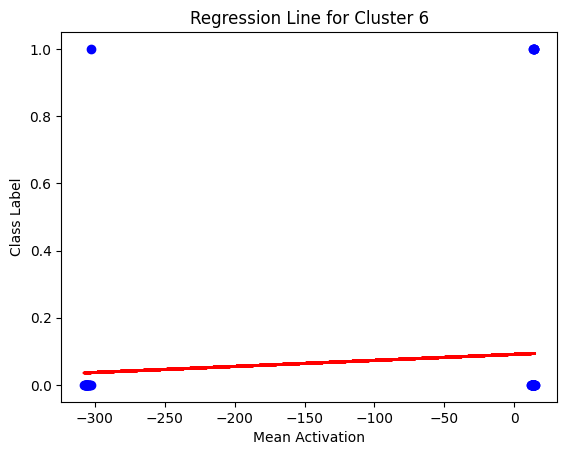

Fitting regression for cluster 7
R2 Score: 0.006532192481404464


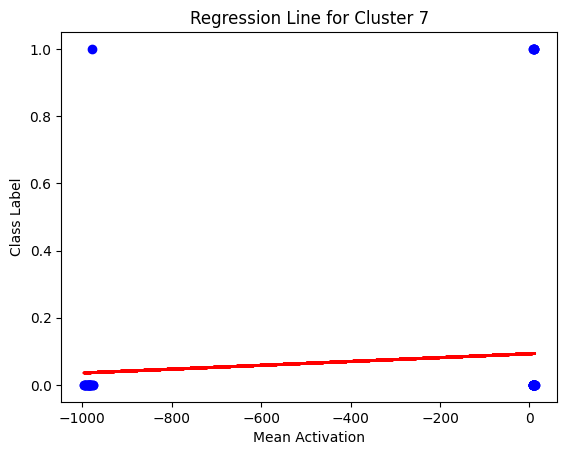

Fitting regression for cluster 8
R2 Score: 0.00642076546516257


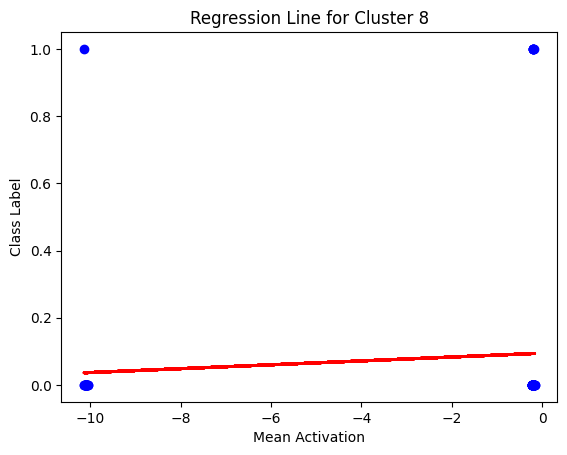

Fitting regression for cluster 9
R2 Score: 0.006380872564890838


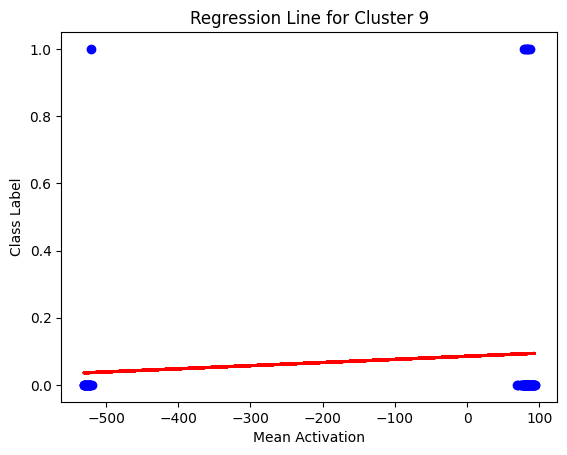

Fitting regression for cluster 10
R2 Score: 0.006336701784410148


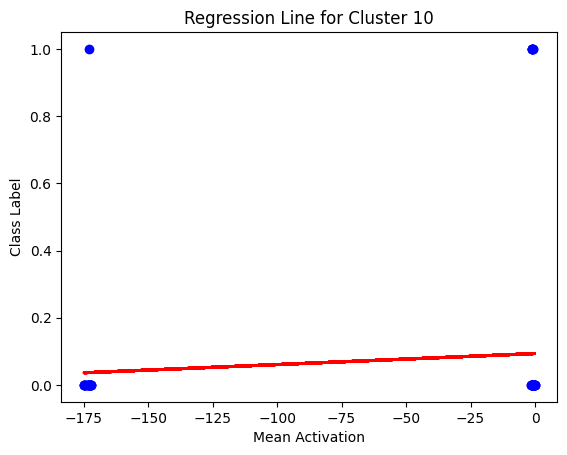

Fitting regression for cluster 11
R2 Score: 0.00615303384114263


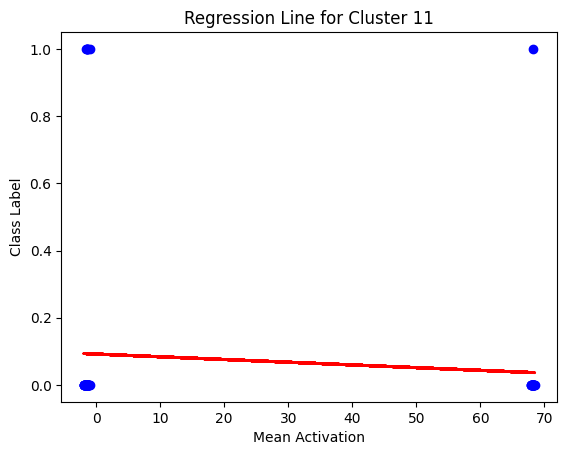

Fitting regression for cluster 12
R2 Score: 0.013899103131693402


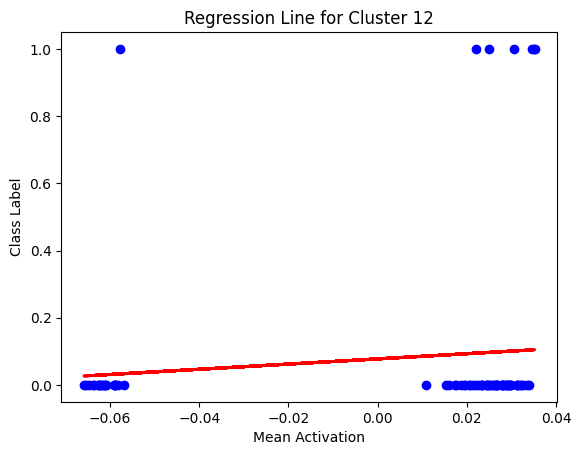

Fitting regression for cluster 13
R2 Score: 0.006565987112799987


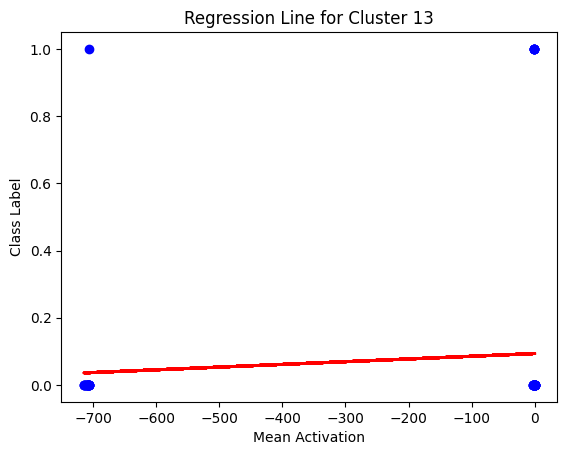

R2 values by cluster:
Cluster 12: 0.013899103131693402
Cluster 6: 0.00669401828112004
Cluster 13: 0.006565987112799987
Cluster 7: 0.006532192481404464
Cluster 0: 0.0065234656142464376
Cluster 3: 0.006506912840079315
Cluster 1: 0.006500852481743147
Cluster 4: 0.006487448182953215
Cluster 8: 0.00642076546516257
Cluster 5: 0.006389071629759657
Cluster 9: 0.006380872564890838
Cluster 10: 0.006336701784410148
Cluster 2: 0.006215132205194318
Cluster 11: 0.00615303384114263
--------------------
Selected Class:  Socrates


In [ ]:
# Set the question ids to different classes
all_classes = clustered_activations_df['question_class'].unique()

for select_class in all_classes:
    print("Selected Class: ", select_class)
    regression_loo(select_class)
    print('--'*10)

In [ ]:
# import numpy as np
# import pandas as pd
# import cudf
# import cuml
# from collections import defaultdict
# import matplotlib.pyplot as plt

# correlation_results = defaultdict(list)


# for class_name, trials in all_prompt_activations_with_class.items():
#     for cluster_id in range(16):  # Assuming you have 16 clusters
#         cluster_neurons = df.loc[df['cluster'] == cluster_id].index.to_numpy()
#         num_neurons = len(cluster_neurons)

#         correlation_sum = 0
#         for trial in trials:
#             cluster_activations = trial[cluster_neurons]
# #             correlation_sum += np.corrcoef(trial, cluster_activations)[0, 1]
#             correlation_sum += np.mean(cluster_activations)

#         average_correlation = correlation_sum / len(trials)
#         correlation_results[class_name].append((cluster_id, num_neurons, average_correlation))

# # Now let's get top 5 clusters for each class
# for class_name, correlations in correlation_results.items():
#     correlations.sort(key=lambda x: x[2], reverse=True)  # Sort by correlation value in descending order
#     top_5_clusters = correlations[:5]

#     print(f"For class {class_name}, the top 5 clusters are:")
#     for cluster_id, num_neurons, correlation in top_5_clusters:
#         print(f"Cluster ID: {cluster_id}, Number of neurons: {num_neurons}, Mean activation: {correlation}")
#     print()


In [ ]:
# Create a list to store dictionaries
data = []
n_clusters = 16

for class_name, trials in all_prompt_activations_with_class.items():
    print(class_name)
    for trial_id, trial in enumerate(trials):
        trial_dict = {'class_id': class_name}
        for cluster_id in range(n_cluster):  # Assuming you have 16 clusters
            cluster_neurons = df.loc[df['cluster'] == cluster_id].index.to_numpy()

            cluster_activations = trial[cluster_neurons]
            trial_dict['cluster_' + str(cluster_id)] = np.mean(cluster_activations)  # Add mean activation to the dictionary
            
        # Append the dictionary to the list
        data.append(trial_dict)

# Convert list of dictionaries to DataFrame
mean_cluster_activations_per_trial = pd.DataFrame(data)


In [ ]:
import statsmodels.api as sm

# Get unique class IDs
class_ids = mean_cluster_activations_per_trial['class_id'].unique()

# For each class ID, run a regression
for class_id in class_ids:
    # Prepare the data
    class_df = mean_cluster_activations_per_trial[mean_cluster_activations_per_trial['class_id'] == class_id]
    X = class_df.drop('class_id', axis=1)
    y = class_df['class_id']

    # Add a constant to the predictors
    X = sm.add_constant(X)

    # Perform OLS regression
    model = sm.OLS(y, X).fit()
    
    # Display the summary statistics of the regression model
    print(f"Class ID: {class_id}")
    print(model.summary())
    print("\n-----------------------------\n")

In [ ]:
from cuml.linear_model import LogisticRegression
import cupy as cp

# Get unique class IDs
class_ids = mean_cluster_activations_per_trial['class_id'].unique()

# For each class ID, run a logistic regression
for class_id in class_ids:
    # Prepare the data
    y = mean_cluster_activations_per_trial['class_id'] == class_id
    X = cp.asarray(mean_cluster_activations_per_trial.drop('class_id', axis=1)).astype(cp.float32)
    y = cp.asarray(y.astype(int))  # Convert boolean values to int (1 for class of interest, 0 for all others)

    # Perform Logistic Regression
    model = LogisticRegression()
    model.fit(X, y)
    
    # Display the coefficients of the logistic regression model
    print(f"Class ID: {class_id}")
    print(f"Intercept: {model.intercept_}")
    print(f"Coefficients: {model.coef_}")
    # print the coefficients in descending order and the corresponding cluster ids
    print(f"Top 5 clusters: {cp.argsort(model.coef_)[0, ::-1][:5]}")
    print("\n-----------------------------\n")


[W] [18:23:52.275339] L-BFGS line search failed (code 4); stopping at the last valid step
Class ID: Ada Lovelace
Intercept: [-6.4875245e-08]
Coefficients: [[-6.00275598e-05  1.92644977e-04 -1.97161176e-09 -1.33744747e-04
  -2.27602886e-05  4.78152378e-06  1.11343925e-05  2.96447115e-06
   1.61020780e-05 -1.08026006e-06  8.65113350e-07  4.80426525e-06
   5.18768275e-06  4.08482992e-06  1.72263000e-07 -1.73606125e-07]]
Top 5 clusters: [ 1  8  6 12 11]

-----------------------------

[W] [18:23:54.052978] L-BFGS line search failed (code 4); stopping at the last valid step
Class ID: Vincent Van Gogh
Intercept: [-5.580048e-08]
Coefficients: [[-6.0078582e-05  1.9257356e-04 -1.6866875e-09 -1.3373610e-04
  -2.2813798e-05  5.3574108e-06  1.1137217e-05  2.9502542e-06
   1.6205873e-05 -1.0924251e-06  8.6834223e-07  5.7107059e-06
   5.3478343e-06  4.1862841e-06  1.7063915e-07 -1.7221967e-07]]
Top 5 clusters: [ 1  8  6 11  5]

-----------------------------

Class ID: Princess Leia
Intercept: [-23.3